In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import statsmodels as sm
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, recall_score, f1_score, precision_score, plot_roc_curve, RocCurveDisplay, auc, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.pipeline import Pipeline
from factor_analyzer import FactorAnalyzer

# Algoritmos no supervisados
![img](img.png)

![img2](img2.png);

In [174]:
df = pd.read_csv('flights.csv', index_col = 0).set_index('id')
df = df.loc[:,'Inflight wifi service':].drop(columns = ['Departure Delay in Minutes', 'Arrival Delay in Minutes'])
df.head()

X = df.drop(columns = 'satisfaction')
y = df.satisfaction
print(X.shape)
print(y.shape)

(103904, 14)
(103904,)


In [175]:
## ML

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)
X_train.shape, X_test.shape

((72732, 14), (31172, 14))

In [176]:
# Chequear si podemos utilizar factor analyzer...
from factor_analyzer import calculate_bartlett_sphericity
_, p_value = calculate_bartlett_sphericity(X_train)
p_value #p_value tiene que ser menor que un nivel de significancia 0.05, OK para poder usar factor analyzer

0.0

In [177]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(X_train)
kmo_model # si kmo_model es menor a 0.6 el factor analyzer no se puede hacer... 0.7 dice la lectura

0.7817735039544463

In [178]:
kmo_all > 0.6

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [179]:
# Si paso estos dos test entonces podemos usar factor analyzer
# Factor analyzer propiamente tal.add()
fa = FactorAnalyzer()
fa.fit(X_train)
# ev eigenvalues...a
ev, _ = fa.get_eigenvalues()
ev

array([3.81315314, 2.35989984, 2.15936881, 1.06360964, 0.94894785,
       0.69967987, 0.54166332, 0.51324235, 0.46804153, 0.36997956,
       0.32758837, 0.29482877, 0.25259897, 0.18739798])

In [180]:
ev.shape

(14,)

Text(0.5, 1.0, 'Scree Plot')

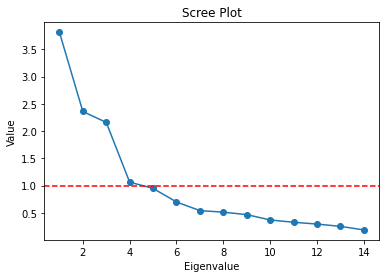

In [181]:
# plt.plot(range(0, len(ev)), ev)
plt.plot(range(1, ev.shape[0]+1), ev, '-o'); plt.xlabel('Eigenvalue'); plt.ylabel('Value')
plt.axhline(y=1, c = 'r', linestyle = '--')
plt.title('Scree Plot')

# Factor analyzer nos da la posibilidad de comprimir 14 variables en 3. Por eso es un algoritmo de reducción de dimensionalidad

In [182]:
## Reduccion de dimensionalidad es distinto de Seleccion de variables.

## Reducción de dimensionalidad ... 3 variables nuevas
fa = FactorAnalyzer(n_factors = 3, rotation = 'varimax')
fa.fit(X_train)


FactorAnalyzer(rotation='varimax', rotation_kwargs={})

In [183]:
loads = pd.DataFrame(fa.loadings_, index = X_train.columns)
loads

,0,1,2
Inflight wifi service,0.170308,0.127952,0.759457
Departure/Arrival time convenient,-0.029864,0.061315,0.498887
Ease of Online booking,0.028935,0.025007,0.932911
Gate location,-0.034266,-0.029237,0.503489
Food and drink,0.754062,0.011911,0.006675
Online boarding,0.395235,0.113187,0.362383
Seat comfort,0.791946,0.082504,0.028082
Inflight entertainment,0.745451,0.467370,0.011994
On-board service,0.094056,0.699792,0.031933
Leg room service,0.077292,0.482453,0.080550


In [184]:
loads.sort_values(by = 0, ascending = False)[0].head() # Revisando las primeras cinco cargas latentes podría concluir arbitrariamente que la primera carga tiene que ver con Comodidad

Cleanliness               0.857061
Seat comfort              0.791946
Food and drink            0.754062
Inflight entertainment    0.745451
Online boarding           0.395235
Name: 0, dtype: float64

In [185]:
loads.sort_values(by = 1, ascending = False)[1].head() # Revisando las segundas cinco cargas latentes podría concluir arbitrariamente que la segunda carga tiene que ver con Servicio

Inflight service          0.801765
Baggage handling          0.761423
On-board service          0.699792
Leg room service          0.482453
Inflight entertainment    0.467370
Name: 1, dtype: float64

In [186]:
loads.sort_values(by = 2, ascending = False)[2].head() # Revisando las terceras cinco cargas latentes podría concluir arbitrariamente que la tercera carga tiene que ver con Conveniencia

Ease of Online booking               0.932911
Inflight wifi service                0.759457
Gate location                        0.503489
Departure/Arrival time convenient    0.498887
Online boarding                      0.362383
Name: 2, dtype: float64

In [187]:
pd.Series(X_train.columns)

0                 Inflight wifi service
1     Departure/Arrival time convenient
2                Ease of Online booking
3                         Gate location
4                        Food and drink
5                       Online boarding
6                          Seat comfort
7                Inflight entertainment
8                      On-board service
9                      Leg room service
10                     Baggage handling
11                      Checkin service
12                     Inflight service
13                          Cleanliness
dtype: object

In [188]:
X_train_factor = pd.DataFrame(fa.transform(X_train), columns = ['Comodidad', 'Servicio', 'Conveniencia'])
X_test_factor = pd.DataFrame(fa.transform(X_test), columns = ['Comodidad', 'Servicio', 'Conveniencia'])

X_train_factor

,Comodidad,Servicio,Conveniencia
0,1.398928,-0.320761,0.094666
1,0.551007,0.775194,-0.592736
2,-2.062790,0.452761,-0.471457
3,0.347396,0.964952,0.814403
4,-1.658572,-0.730483,1.583103
...,...,...,...
72727,1.434513,-0.870034,-1.761844
72728,-1.207369,0.376178,1.836859
72729,1.364353,0.315410,1.520889
72730,0.271267,-0.637308,0.957890


In [189]:
X_complete_train = pd.concat([X_train.reset_index(drop = True), X_train_factor], axis = 1)
X_complete_test= pd.concat([X_test.reset_index(drop = True), X_test_factor], axis = 1)
X_complete_train

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Comodidad,Servicio,Conveniencia
0,3,2,3,4,5,3,5,5,4,4,3,2,3,5,1.398928,-0.320761,0.094666
1,2,2,2,5,5,2,2,5,5,2,4,4,5,5,0.551007,0.775194,-0.592736
2,2,2,2,3,1,2,1,1,3,3,4,4,5,1,-2.062790,0.452761,-0.471457
3,4,4,4,3,4,4,4,4,4,5,5,3,5,4,0.347396,0.964952,0.814403
4,5,4,5,2,1,5,1,1,2,1,2,3,4,1,-1.658572,-0.730483,1.583103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72727,0,4,0,3,5,0,5,5,2,3,3,5,2,5,1.434513,-0.870034,-1.761844
72728,5,5,5,4,1,5,5,1,3,4,4,4,5,1,-1.207369,0.376178,1.836859
72729,5,5,5,3,5,5,5,5,4,4,4,3,4,5,1.364353,0.315410,1.520889
72730,4,4,4,4,4,2,2,3,3,3,3,4,3,5,0.271267,-0.637308,0.957890


In [190]:
# 3 maneras de resolverlo...
X_train, y_train
X_train_factor, y_train
X_complete_train, y_train
print()

In [191]:
## Multicolinealidad.... Impacta cuando queremos explicar...

In [192]:
## Regresión Logística
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr1 = LogisticRegression(random_state = 123)
lr1.fit(X_train, y_train)
y_pred1 = lr1.predict(X_test)
accuracy_score(y_test, y_pred1)   # modelo baseline.... Base

0.8167586295393302

In [193]:
lr1.coef_

array([[ 0.29543251, -0.29150465, -0.12589402,  0.12566098, -0.07237294,
         0.82103533,  0.1623295 ,  0.29310452,  0.27089373,  0.34984344,
         0.06743807,  0.21679037,  0.0094936 ,  0.04225774]])

In [194]:
## Regresión Logística
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr2 = LogisticRegression(random_state = 123)
lr2.fit(X_train_factor, y_train)
y_pred2 = lr2.predict(X_test_factor)
accuracy_score(y_test, y_pred2)   # esperable que baje: 14 variables y ahora tienes 3...Dejar solo las 3 sirven para explicar mejor el modelo

0.7343128448607725

In [195]:
lr2.coef_

array([[0.92931151, 0.92991289, 0.42534443]])

In [196]:
## Regresión Logística
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr3 = LogisticRegression(random_state=123)
lr3.fit(X_complete_train, y_train)
y_pred3 = lr3.predict(X_complete_test)
accuracy_score(y_test, y_pred3)   # agregar 3 variables, sirven para mejorar el modelo aunque sea leve el aumento de la mejora.


0.8167907096111895

In [197]:
lr3.coef_

array([[ 1.51809699e-01, -3.23970639e-01, -4.15266812e-01,
         1.32007444e-01, -1.07534684e-01,  7.80417149e-01,
         3.33640692e-04, -8.35900971e-02,  7.76259697e-02,
         2.74378793e-01, -1.90854478e-01,  1.34204277e-01,
        -2.97856794e-01, -1.42030732e-01,  9.63010368e-01,
         1.25904318e+00,  6.53251313e-01]])

# PCA

In [201]:
from sklearn.datasets import load_iris

data = load_iris(as_frame = True)
X = data.data
y = data.target
X

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


![](iris.png)
![](pca.png)

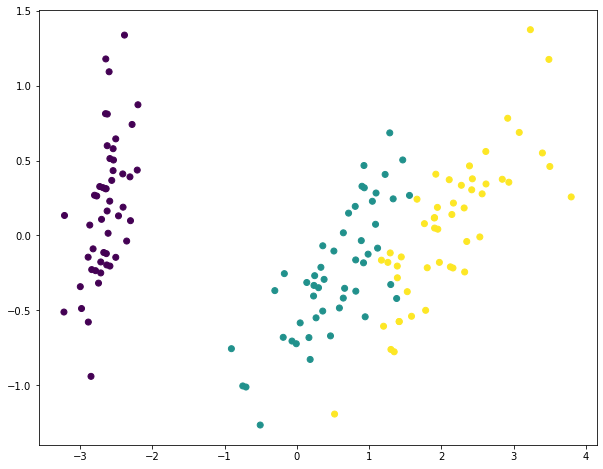

In [209]:
## Visualizar datasets de alta dimensionalidad...

from sklearn.decomposition import PCA # UMAP (UMAP), T-sne (sklearn)
 

pca = PCA(n_components = 2) # yo la puedo graficar...

X_reducido = pca.fit_transform(X)

plt.figure(figsize = (10,8))
plt.scatter(X_reducido[:, 0], X_reducido[:, 1], c = y);



# Modelamiento ...

In [211]:
X_train

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness
id,,,,,,,,,,,,,,
7023,3,2,3,4,5,3,5,5,4,4,3,2,3,5
104825,2,2,2,5,5,2,2,5,5,2,4,4,5,5
63463,2,2,2,3,1,2,1,1,3,3,4,4,5,1
115365,4,4,4,3,4,4,4,4,4,5,5,3,5,4
85294,5,4,5,2,1,5,1,1,2,1,2,3,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12834,0,4,0,3,5,0,5,5,2,3,3,5,2,5
5355,5,5,5,4,1,5,5,1,3,4,4,4,5,1
23311,5,5,5,3,5,5,5,5,4,4,4,3,4,5


<AxesSubplot:>

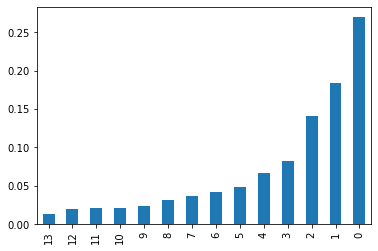

In [215]:
pca = PCA(random_state = 123)
pca.fit(X_train)
pd.Series(pca.explained_variance_ratio_).sort_values().plot(kind = 'bar')

In [224]:
variance = pd.Series(pca.explained_variance_ratio_).cumsum().sort_values(ascending = True)
variance

0     0.269778
1     0.454051
2     0.594843
3     0.676753
4     0.743061
5     0.791753
6     0.834048
7     0.869968
8     0.900939
9     0.924696
10    0.945971
11    0.967100
12    0.986574
13    1.000000
dtype: float64

In [226]:
pca = PCA(n_components = 0.9, random_state = 123)
pca.fit(X_train) # PCA es un algoritmo no supervisado...

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

lr = LogisticRegression(random_state = 123)
lr.fit(X_train_pca, y_train)

y_pred = lr.predict(X_test_pca)

accuracy_score(y_test, y_pred)     # Ojo que el PCA es caro...

0.8110483767483639

In [230]:
pipe = Pipeline(steps = [
    ('pca', PCA(n_components=0.9, random_state = 123)),
    ('lr', LogisticRegression(random_state = 123))
    ])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

accuracy_score(y_test, y_pred)

0.8110483767483639

## factor analyzer no es compatible con Pipeline...